In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import *
import yfinance as yf
import os
plt.style.use('ggplot')

In [10]:
data = pd.read_csv('/content/stock_tweets.csv')
data.head()

,Date,Tweet,Stock Name,Company Name
0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc."
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc."
2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc."
3,2022-09-29 22:40:07+00:00,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,"Tesla, Inc."
4,2022-09-29 22:27:05+00:00,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,"Tesla, Inc."


In [13]:
data['Date']=pd.to_datetime(data['Date'])
daily_counts = data.groupby(['Date','Stock Name']).size().reset_index(name='tweet_count')
daily_counts.head()

,Date,Stock Name,tweet_count
0,2021-09-30 00:06:02+00:00,GOOG,1
1,2021-09-30 00:13:26+00:00,TSM,1
2,2021-09-30 00:14:49+00:00,TSM,1
3,2021-09-30 00:16:45+00:00,TSM,1
4,2021-09-30 00:24:50+00:00,TSM,1


In [15]:
total_tweets = data.groupby('Date').size().reset_index(name='total_tweets')
engagement_df= daily_counts.merge(total_tweets, on='Date', how='left')
engagement_df['engagement_rate'] = engagement_df['tweet_count'] / engagement_df['total_tweets']
engagement_df.head()

,Date,Stock Name,tweet_count,total_tweets,engagement_rate
0,2021-09-30 00:06:02+00:00,GOOG,1,1,1.0
1,2021-09-30 00:13:26+00:00,TSM,1,1,1.0
2,2021-09-30 00:14:49+00:00,TSM,1,1,1.0
3,2021-09-30 00:16:45+00:00,TSM,1,1,1.0
4,2021-09-30 00:24:50+00:00,TSM,1,1,1.0


In [19]:
from textblob import TextBlob

def get_sentiment(text):
    return TextBlob(text).sentiment.polarity  # -1 to 1

data['sentiment'] = data['Tweet'].apply(get_sentiment)
data['sentiment_weight'] = data['sentiment'].abs()

# Weighted tweet count
data['weighted_count'] = data['sentiment_weight']

# Recompute daily weighted engagement
weighted_daily = data.groupby(['Date', 'Stock Name'])['weighted_count'].sum().reset_index()
total_weighted = data.groupby('Date')['weighted_count'].sum().reset_index(name='total_weighted')

weighted_df = weighted_daily.merge(total_weighted, on='Date')
weighted_df['engagement_rate_weighted'] = weighted_df['weighted_count'] / weighted_df['total_weighted']

In [22]:
import pandas as pd

# Assuming engagement_df has ['Date', 'Stock Name', 'engagement_rate']
engagement_df['month'] = engagement_df['Date'].dt.to_period('M')

# Average engagement per stock per month
monthly_avg = (
    engagement_df
    .groupby(['month', 'Stock Name'])['engagement_rate']
    .mean()
    .reset_index()
)

# Rank stocks within each month (highest engagement = rank 1)
monthly_avg['rank'] = monthly_avg.groupby('month')['engagement_rate'] \
                                 .rank(method='first', ascending=False)

# Top 5 stocks for each month
top5_monthly = monthly_avg[monthly_avg['rank'] <= 5] \
                .sort_values(['month', 'rank'])

/tmp/ipython-input-2567973644.py:4: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  engagement_df['month'] = engagement_df['Date'].dt.to_period('M')


In [24]:
for month, group in top5_monthly.groupby('month'):
    print(f"\nTop 5 Stocks for {month}:")
    print(group[['rank', 'Stock Name', 'engagement_rate']])


Top 5 Stocks for 2021-09:
    rank Stock Name  engagement_rate
3    1.0        DIS              1.0
4    2.0       GOOG              1.0
5    3.0       META              1.0
11   4.0        TSM              1.0
12   5.0       XPEV              1.0

Top 5 Stocks for 2021-10:
    rank Stock Name  engagement_rate
34   1.0        TSM         0.992352
33   2.0       TSLA         0.963288
29   3.0        NIO         0.864874
26   4.0       META         0.815622
32   5.0       PYPL         0.814395

Top 5 Stocks for 2021-11:
    rank Stock Name  engagement_rate
59   1.0        TSM         0.988439
58   2.0       TSLA         0.957770
54   3.0        NIO         0.868734
43   4.0       COST         0.751852
39   5.0        AMD         0.733982

Top 5 Stocks for 2021-12:
    rank Stock Name  engagement_rate
67   1.0         BX         1.000000
84   2.0        TSM         0.986133
83   3.0       TSLA         0.950346
79   4.0        NIO         0.893902
87   5.0         ZS         0.873333

Top

In [31]:
# Shift month by 1 to use "previous month's top 5" for the current month
top5_monthly['portfolio_month'] = top5_monthly['month'] + 1  # period type supports +1 month

In [32]:
# Group stocks into a list for each portfolio_month
portfolios = (
    top5_monthly.groupby('portfolio_month')['Stock Name']
    .apply(list)
    .reset_index(name='portfolio_stocks')
)

# Drop any incomplete months (e.g., first month has no previous month data)
portfolios = portfolios.dropna()


In [34]:
prices_df = pd.read_csv('/content/stock_yfinance_data.csv')
prices_df['Date'] = pd.to_datetime(prices_df['Date'])
prices_df = prices_df.set_index('Date').sort_index()

In [41]:
#Monthly portfolio returns

def monthly_portfolio_returns(portfolios_df, prices):
    # Pivot the prices DataFrame so tickers are columns and date is the index
    prices_pivot = prices.pivot_table(index='Date', columns='Stock Name', values='Adj Close')

    monthly_first = prices_pivot.resample('MS').first()
    monthly_last = prices_pivot.resample('ME').last() # Changed 'M' to 'ME'

    results = []
    months = []

    for index, row in portfolios_df.iterrows():
        month = row['portfolio_month']
        tickers = row['portfolio_stocks']

        m_start = month.to_timestamp()
        m_end = month.to_timestamp('M')

        if m_start not in monthly_first.index or m_end not in monthly_last.index:
            continue

        # Ensure tickers are present in the monthly price data before selecting
        valid_tickers = [t for t in tickers if t in monthly_first.columns]
        if not valid_tickers:
            print(f"No valid tickers with price data for {month}. Skipping.")
            continue

        start_prices = monthly_first.loc[m_start, valid_tickers].dropna()
        end_prices = monthly_last.loc[m_end, start_prices.index].dropna()


        if start_prices.empty or end_prices.empty:
            continue

        month_returns = (end_prices - start_prices) / start_prices
        portfolio_return = month_returns.mean()
        results.append(portfolio_return)
        months.append(m_end)

    return pd.Series(results, index=pd.to_datetime(months))

port_rets = monthly_portfolio_returns(portfolios, prices_df)

In [47]:
print(port_rets)

2021-10-31    0.064922
2021-11-30   -0.057088
2021-12-31   -0.033996
2022-01-31   -0.128171
2022-02-28   -0.099435
2022-03-31    0.018746
2022-04-30   -0.175838
2022-05-31   -0.085005
2022-06-30   -0.014713
2022-07-31    0.187173
2022-08-31   -0.009126
2022-09-30   -0.107812
dtype: float64


In [42]:
benchmark_ticker = '^IXIC'  # change if your CSV has different label
if benchmark_ticker in prices_df.columns:
    bm_prices = prices_df[[benchmark_ticker]]
    bm_first = bm_prices.resample('MS').first()
    bm_last = bm_prices.resample('M').last()
    bm_rets = ((bm_last - bm_first) / bm_first).iloc[:, 0]
    bm_rets.index = pd.to_datetime(bm_rets.index)
else:
    bm_rets = None

In [43]:
port_cum = (1 + port_rets).cumprod() - 1
if bm_rets is not None:
    bm_cum = (1 + bm_rets).cumprod() - 1

print("\nStrategy cumulative return:", port_cum.iloc[-1])
if bm_rets is not None:
    print("Benchmark cumulative return:", bm_cum.iloc[-1])


Strategy cumulative return: -0.39498940574649155


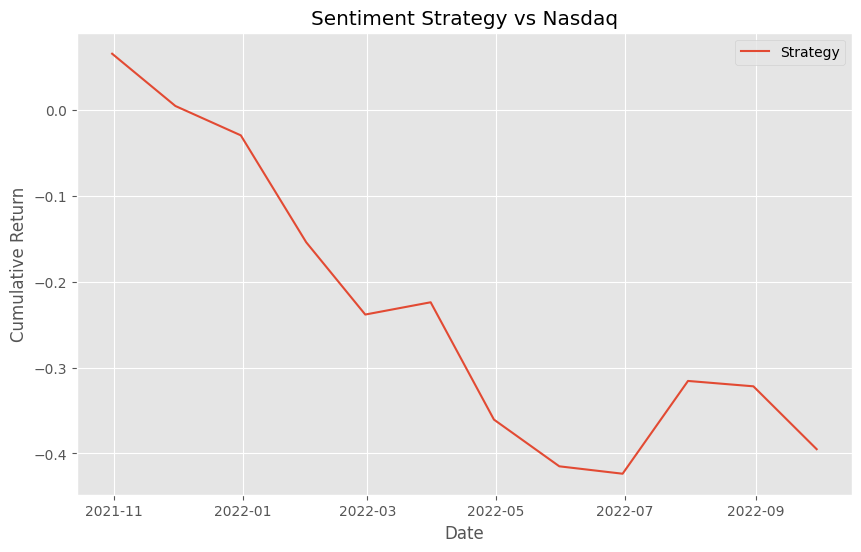

In [45]:
plt.figure(figsize=(10,6))
plt.plot(port_cum.index, port_cum.values, label="Strategy")
if bm_rets is not None:
    plt.plot(bm_cum.index, bm_cum.values, label="Benchmark (Nasdaq)")
plt.legend()
plt.title("Sentiment Strategy vs Nasdaq")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.show()

/tmp/ipython-input-397266652.py:32: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_yf = yf.download(tickers, start=start, end=end, progress=False, threads=True)


Downloaded data columns: MultiIndex([( 'Close',  'AMD'),
            ( 'Close',   'BX'),
            ( 'Close', 'COST'),
            ( 'Close',  'CRM'),
            ( 'Close',  'DIS'),
            ( 'Close', 'ENPH'),
            ( 'Close', 'GOOG'),
            ( 'Close', 'META'),
            ( 'Close', 'NFLX'),
            ( 'Close',  'NIO'),
            ( 'Close', 'PYPL'),
            ( 'Close', 'TSLA'),
            ( 'Close',  'TSM'),
            ( 'Close', 'XPEV'),
            ( 'Close',   'ZS'),
            (  'High',  'AMD'),
            (  'High',   'BX'),
            (  'High', 'COST'),
            (  'High',  'CRM'),
            (  'High',  'DIS'),
            (  'High', 'ENPH'),
            (  'High', 'GOOG'),
            (  'High', 'META'),
            (  'High', 'NFLX'),
            (  'High',  'NIO'),
            (  'High', 'PYPL'),
            (  'High', 'TSLA'),
            (  'High',  'TSM'),
            (  'High', 'XPEV'),
            (  'High',   'ZS'),
            (  

/tmp/ipython-input-397266652.py:62: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_last = adj_close_df.resample('M').last()    # month end last price
/tmp/ipython-input-397266652.py:32: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_yf = yf.download(tickers, start=start, end=end, progress=False, threads=True)
/tmp/ipython-input-397266652.py:130: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_prices = adj.resample('M').last()


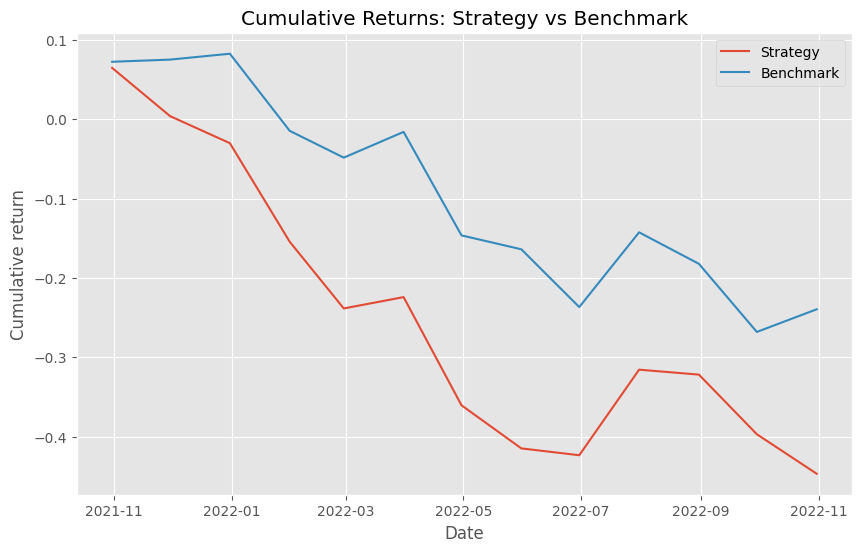

In [56]:
def cagr(cum_returns, periods_per_year=12):
    # cum_returns is cumulative return series indexed by month-end
    n_periods = len(cum_returns) - 1
    if n_periods <= 0:
        return np.nan
    total_return = cum_returns.iloc[-1]
    return (1 + total_return) ** (periods_per_year / n_periods) - 1

def annualized_vol(returns, periods_per_year=12):
    return returns.std() * np.sqrt(periods_per_year)

def sharpe_ratio(returns, rf=0.0, periods_per_year=12):
    excess = returns - (rf / periods_per_year)
    ann_excess = excess.mean() * periods_per_year
    ann_vol = excess.std() * np.sqrt(periods_per_year)
    if ann_vol == 0:
        return np.nan
    return ann_excess / ann_vol

def max_drawdown(cum_ret_series):
    # cum_ret_series expressed as cumulative returns e.g. (1+ret).cumprod()-1 or running cumulative factor
    cum_factor = (1 + cum_ret_series).cumprod()
    peak = cum_factor.cummax()
    drawdown = (cum_factor - peak) / peak
    return drawdown.min()

# -------------------------
# Price download + resample
# -------------------------
def download_adj_close(tickers, start, end):
    """Return DataFrame of adj close (daily) for tickers"""
    data_yf = yf.download(tickers, start=start, end=end, progress=False, threads=True)
    print("Downloaded data columns:", data_yf.columns) # Print columns for debugging

    if isinstance(data_yf, pd.DataFrame):
        if 'Adj Close' in data_yf.columns:
            data_yf = data_yf['Adj Close']
        elif 'Close' in data_yf.columns:
            print("Using 'Close' column as 'Adj Close' not found.")
            data_yf = data_yf['Close']
        else:
            raise KeyError("Neither 'Adj Close' nor 'Close' column found in downloaded data.")
    elif isinstance(data_yf, pd.Series):
         # If single ticker, it might already be the price series
         pass # data is already a Series, assume it's the price

    # If single ticker, make DataFrame
    if isinstance(data_yf, pd.Series):
        data_yf = data_yf.to_frame()
    data_yf = data_yf.sort_index()
    data_yf.index = pd.to_datetime(data_yf.index) # Explicitly convert index to DatetimeIndex
    return data_yf


def monthly_price_at_month_start(adj_close_df):
    """
    Convert daily adj_close to price at first trading day of each month and last trading day of each month.
    We'll use first trading day price to simulate entering the month (after rebalancing).
    """
    # Resample to month start by taking first valid price in month
    monthly_first = adj_close_df.resample('MS').first()  # MS = month start
    monthly_last = adj_close_df.resample('M').last()    # month end last price
    # Keep only months where we have data for at least one day
    monthly_first = monthly_first.dropna(how='all')
    monthly_last = monthly_last.dropna(how='all')
    return monthly_first, monthly_last

# -------------------------
# Build monthly rebalanced portfolio returns
# -------------------------
def build_monthly_portfolio_returns(portfolios, start, end):
    """
    portfolios: dict mapping pd.Period('YYYY-MM') or 'YYYY-MM' -> list of tickers for the portfolio to hold that month.
                The key should be the month WHEN you HOLD the portfolio (e.g., 2024-07 means hold through July 2024).
                Typically you assign month M's portfolio from previous-month signals.
    start/end: date strings for price download buffer (ensure includes month before first portfolio period)
    Returns:
      monthly_portfolio_returns: pd.Series indexed by month-end (period) with equal-weight portfolio returns for each month.
      price_tables: dictionary containing monthly_first and monthly_last price tables (for debugging)
    """
    # Get full set of tickers we need
    all_tickers = sorted({t for lst in portfolios.values() for t in lst})
    # Download prices
    adj_close = download_adj_close(all_tickers, start, end)
    monthly_first, monthly_last = monthly_price_at_month_start(adj_close)

    # We'll compute returns for each month: (price_at_end / price_at_start) - 1 for each ticker in universe
    # Align months: use index of monthly_first as months we can enter. We'll compute returns for months present in portfolios
    results = []
    months = []
    for month_str, tickers in portfolios.items():
        # normalize key to period object
        if not isinstance(month_str, pd.Period):
            month = pd.Period(str(month_str), freq='M')
        else:
            month = month_str
        # get month start price (first trading day) and month end price (last trading day)
        try:
            start_price = monthly_first.loc[month.to_timestamp()]  # timestamp at month start
            end_price = monthly_last.loc[month.to_timestamp('M')]
        except KeyError:
            # Missing data for this month -> skip (or handle differently)
            print(f"Skipping {month} because price data missing.")
            continue
        # Filter to tickers in this portfolio (some tickers may be missing prices -> drop them for that month)
        start_price = start_price[tickers].dropna()
        end_price = end_price[start_price.index] if not start_price.empty else pd.Series(dtype=float)
        if start_price.empty or end_price.isna().all().all(): # Added .all() to check if all values are NA
            print(f"No valid tickers with prices for {month}. Skipping.")
            continue
        # compute returns
        month_returns = (end_price - start_price) / start_price
        # equal-weight across available tickers
        eq_weight = 1.0 / len(month_returns)
        portfolio_return = (month_returns * eq_weight).sum()
        results.append(portfolio_return)
        months.append(month.to_timestamp('M'))  # use month-end timestamp for indexing

    monthly_portfolio_returns = pd.Series(results, index=pd.to_datetime(months)).sort_index()
    return monthly_portfolio_returns, {'monthly_first': monthly_first, 'monthly_last': monthly_last}

# -------------------------
# Compare vs benchmark
# -------------------------
def benchmark_monthly_returns(benchmark_ticker, start, end):
    adj = download_adj_close([benchmark_ticker], start, end)
    print("\nBenchmark daily adj close (head):\n", adj.head()) # Debug print

    # Calculate monthly returns based on last price of consecutive months
    monthly_prices = adj.resample('M').last()
    print("\nBenchmark monthly last prices (head):\n", monthly_prices.head()) # Debug print

    # Calculate returns
    bm_returns = monthly_prices.pct_change().dropna()

    # Ensure index is datetime at month-end
    bm_returns.index = pd.to_datetime(bm_returns.index).to_period('M').to_timestamp('M')

    print("\nCalculated benchmark returns (head):\n", bm_returns.head()) # Debug print
    return bm_returns.iloc[:, 0] # Return as Series


# -------------------------
# Example usage
# -------------------------

# Get portfolio months from the 'portfolios' DataFrame
example_portfolios = {row['portfolio_month']: row['portfolio_stocks'] for index, row in portfolios.iterrows()}

# Determine download window: a little padding before first month
first_month = min(example_portfolios.keys())
start_date = (first_month - 1).to_timestamp() - pd.Timedelta(days=10)  # buffer
end_date = (max(example_portfolios.keys()).to_timestamp('M') + pd.Timedelta(days=5))


# Build portfolio returns
port_rets, price_tables = build_monthly_portfolio_returns(example_portfolios, start=str(start_date.date()), end=str(end_date.date()))

# Benchmark: Nasdaq Composite
benchmark_ticker = '^IXIC'
bm_rets = benchmark_monthly_returns(benchmark_ticker, start=str(start_date.date()), end=str(end_date.date()))

# Align indexes
common_index = port_rets.index.intersection(bm_rets.index)
port = port_rets.loc[common_index]
bm = bm_rets.loc[common_index]

# Cumulative returns
port_cum = (1 + port).cumprod() - 1
bm_cum = (1 + bm).cumprod() - 1

# Metrics
metrics = {
    'strategy_cagr': cagr(port_cum),
    'benchmark_cagr': cagr(bm_cum),
    'strategy_ann_vol': annualized_vol(port),
    'benchmark_ann_vol': annualized_vol(bm),
    'strategy_sharpe': sharpe_ratio(port),
    'benchmark_sharpe': sharpe_ratio(bm),
    'strategy_max_dd': max_drawdown(port_cum),
    'benchmark_max_dd': max_drawdown(bm_cum),
}
metrics_df = pd.Series(metrics).to_frame('value')

# Print results
print("\nMonthly portfolio returns (head):\n", port.head())
print("\nBenchmark returns (head):\n", bm.head())
print("\nPerformance metrics:\n", metrics_df)

# Plots
plt.figure(figsize=(10,6))
plt.plot(port_cum.index, port_cum.values)
plt.plot(bm_cum.index, bm_cum.values)
plt.title('Cumulative Returns: Strategy vs Benchmark')
plt.legend(['Strategy', 'Benchmark'])
plt.xlabel('Date')
plt.ylabel('Cumulative return')
plt.grid(True)
plt.show()

In [58]:
# Inspect variables created during the execution of cell SvrJoEI1rY93
print("Example Portfolios:")
display(example_portfolios)

print("\nStart Date for Download:")
display(start_date)

print("\nEnd Date for Download:")
display(end_date)

# Since we can't directly access local variables within the functions,
# we'll need to re-run the download with print statements if necessary,
# but let's first check if port_rets and bm_rets from SvrJoEI1rY93 are indeed empty.
print("\nMonthly Portfolio Returns:")
display(port_rets)

print("\nBenchmark Returns:")
display(bm_rets)

# To further diagnose download issues, we could add print statements inside
# the download_adj_close and monthly_price_at_month_start functions in cell SvrJoEI1rY93
# and re-run, but let's see the above first.

Example Portfolios:


{Period('2021-10', 'M'): ['DIS', 'GOOG', 'META', 'TSM', 'XPEV'],
 Period('2021-11', 'M'): ['TSM', 'TSLA', 'NIO', 'META', 'PYPL'],
 Period('2021-12', 'M'): ['TSM', 'TSLA', 'NIO', 'COST', 'AMD'],
 Period('2022-01', 'M'): ['BX', 'TSM', 'TSLA', 'NIO', 'ZS'],
 Period('2022-02', 'M'): ['TSM', 'TSLA', 'NIO', 'ZS', 'NFLX'],
 Period('2022-03', 'M'): ['TSM', 'TSLA', 'NIO', 'ZS', 'DIS'],
 Period('2022-04', 'M'): ['TSM', 'TSLA', 'ZS', 'NIO', 'CRM'],
 Period('2022-05', 'M'): ['TSM', 'TSLA', 'NIO', 'NFLX', 'ZS'],
 Period('2022-06', 'M'): ['TSM', 'TSLA', 'NIO', 'DIS', 'COST'],
 Period('2022-07', 'M'): ['TSM', 'TSLA', 'NIO', 'ENPH', 'DIS'],
 Period('2022-08', 'M'): ['TSM', 'TSLA', 'NIO', 'ENPH', 'DIS'],
 Period('2022-09', 'M'): ['TSM', 'TSLA', 'META', 'ENPH', 'NIO'],
 Period('2022-10', 'M'): ['BX', 'TSM', 'TSLA', 'NIO', 'ENPH']}


Start Date for Download:


Timestamp('2021-08-22 00:00:00')


End Date for Download:


Timestamp('2022-11-05 00:00:00')


Monthly Portfolio Returns:


,0
2021-10-31,0.064922
2021-11-30,-0.057088
2021-12-31,-0.033996
2022-01-31,-0.128171
2022-02-28,-0.099435
2022-03-31,0.018746
2022-04-30,-0.175838
2022-05-31,-0.085005
2022-06-30,-0.014713
2022-07-31,0.187173



Benchmark Returns:


,^IXIC
Date,
2021-09-30,-0.053126
2021-10-31,0.072658
2021-11-30,0.002536
2021-12-31,0.006904
2022-01-31,-0.089811
2022-02-28,-0.034304
2022-03-31,0.034114
2022-04-30,-0.132617
2022-05-31,-0.020532
